# CmpE 545 - Artificial Neural Networks
## Twitter Sentiment Analysis

**Student**: Gonul Ayci <br>
**Instructor**: Prof. Ethem Alpaydin

# Import necessary libraries

In [1]:
import csv
import pandas as pd 
import numpy as np 
from sklearn.utils import shuffle  
import random 
import sklearn 
import nltk 
from nltk.corpus import stopwords 
import re
from nltk.tokenize import word_tokenize 
import matplotlib
import matplotlib.pyplot as plt
from itertools import product

import time
import datetime

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.cross_validation import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read and prepare data

In [2]:
#read and shuffle csv file without header as dataframe
df = pd.read_csv('trainingandtestdata/training.1600000.processed.noemoticon.csv', 
                                                 encoding='latin-1', header=None) 
df = shuffle(df) 
%matplotlib inline

In [3]:
# data
# give column names
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
#drop some column from the dataframe 
df = df.drop(["id", "date", "query", "user"], axis = 1) 
df.head() # get the first 5 rows from the dataframe

,sentiment,text
1187118,4,@Pepsimo Our back garden is gr8..sun all day t...
954983,4,@michaelsheen http://twitpic.com/52m7b - mmmm....
570810,0,mad @eBStAR1 cuz shes not gonna be in NY for m...
977460,4,Sleeping on air
395937,0,my internet is still wonky sad day


In [4]:
# count the number of sentiments with respect to their tweet
# 4 for positive tweet and 0 for negative tweet)
df.sentiment.value_counts() 

4    800000
0    800000
Name: sentiment, dtype: int64

In [5]:
# add new column pre_clean_len to dataframe which is length of each tweet
df['pre_clean_len'] = [len(t) for t in df.text]
# check for any tweets greater than 140 characters
df[df.pre_clean_len > 140].head(10)  
df = df.sample(frac=1)

# Clean tweets

In [8]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'        # remove @ mentions from tweets
pat2 = r'https?://[^ ]+'        # remove URL's from tweets
combined_pat = r'|'.join((pat1, pat2)) #addition of pat1 and pat2
www_pat = r'www.[^ ]+'         # remove URL's from tweets
# converting words like isn't to is not
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", 
                 "weren't":"were not",   
                "haven't":"have not","hasn't":"has not","hadn't":"had not",
                 "won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not",
                 "didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not",
                 "mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):  
    soup = BeautifulSoup(text, 'lxml')    # call beautiful object
    souped = soup.get_text()   # get only text from the tweets 
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")   
    except:
        bom_removed = souped
    
    stripped = re.sub(combined_pat, '', bom_removed) # calling combined_pat
    stripped = re.sub(www_pat, '', stripped) #remove URL's
    lower_case = stripped.lower()      # converting all into lower case
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case) 
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)       
    # Word Punct Tokenize and only consider words whose length is greater than 1
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1] 
    
    return (" ".join(words)).strip() 

In [9]:
# used for batch processing tweets
nums = [0,400000,800000,1200000,1600000]

# initialize list
clean_tweet_texts = [] 

# batch process 1.6 million tweets
for i in range(nums[0],nums[4]):
    # call tweet_cleaner function and pass parameter as all the tweets to clean 
    # the tweets and append cleaned tweets into clean_tweet_texts list
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  

# Clean Tweet Texts

In [10]:
# initialize list for tokens
word_tokens = [] 

# for each word in clean_tweet_texts
for word in clean_tweet_texts:  
    # tokenize word in clean_tweet_texts and append it to word_tokens list
    word_tokens.append(word_tokenize(word)) 

In [ ]:
# word_tokens
# stop = set(stopwords.words('english'))
# clean_df =[]
# for m in word_tokens:
#     a = [w for w in m if not w in stop]
#     clean_df.append(a)

## Lemmatization

In [11]:
# initialize list df1 to store words after lemmatization
df1 = [] 

# create an object of WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

# for loop for every tokens in word_token
for l in word_tokens: 
    #for every tokens in word_token lemmatize word and give it to b
    b = [lemmatizer.lemmatize(q) for q in l] 
    df1.append(b)

## Stemming

In [ ]:
# df1 = [] 

# ps = PorterStemmer()

# for l in word_tokens:
#     b = [ps.stem(q) for q in l]
#     df1.append(b)

In [12]:
# initialize list clean_df1 to join word tokens after lemmatization
clean_df1 =[] 

for c in df1:
    a = " ".join(c) 
    clean_df1.append(a) 

In [13]:
# convert clean_tweet_texts into dataframe and name it as clean_df
clean_df = pd.DataFrame(clean_df1,columns=['text'])
# from earlier dataframe get the sentiments of each tweet and make a new column
# in clean_df as target and give it all the sentiment score
clean_df['target'] = df.sentiment
# Again make a new coloumn in the dataframe and name it as clean_len 
# which will store thw number of words in the tweet
clean_df['clean_len'] = [len(t) for t in clean_df.text] 
# check id any tweet is more than 140 characters
clean_df[clean_df.clean_len > 140].head(10)

,text,target,clean_len


In [ ]:
sum(clean_df['target'] )

In [14]:
for i in range(len(clean_df)):
    if clean_df['text'][i] == "":
        clean_df = clean_df.drop(i)

In [15]:
clean_df.target.value_counts() 

0    798197
4    797844
Name: target, dtype: int64

In [52]:
# Because of the huge size of the dataset, 
#I need to reduce dataset size especially for MLP model
clean_df = clean_df.sample(100000)

In [53]:
# get all the text in x variable
X = clean_df.text 
# get all the sentiments into y variable
y = clean_df.target 
print(X.shape) 
print(y.shape) 

(100000,)
(100000,)


# Split data into train and test

In [54]:
# split the data into traing and testing set where ratio is 80:20
# X_train is the tweets of training data, X_test is the testing tweets 
# which we have to predict, 
# y_train is the sentiments of tweets in the traing data and y_test 
# is the sentiments of the tweets  
# which we will use to measure the accuracy of the model
#bound = 100000
X_train, X_test, y_train, y_test = train_test_split(X[1:], y[1:], 
                                                    test_size = 0.20, random_state= 1) 

# Apply tfidf

In [55]:
# Get Tf-idf object and save it as vect. We can select features 
# from here we just have simply change
# the ngram range to change the features also we can remove stop words
# over here with the help of stop parameter
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3)) 

In [56]:
vect.fit(X_train) # fit or traing data tweets to vect
X_train_dtm = vect.transform(X_train) # transform our training data tweets
X_test_dtm = vect.transform(X_test)# transform our testing data tweets
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Apply word-embedding

In [ ]:
# I use GloVe data for word-embedding.
# There is 25, 50, 100, 200 dimensions version 
# on their website: https://nlp.stanford.edu/projects/glove/
glove_data_file = 'glove.twitter.27B/glove.twitter.27B.25d.txt'
glove_table = pd.read_table(glove_data_file, sep=" ", index_col=0, header=None, 
                                              quoting=csv.QUOTE_NONE)

In [ ]:
start_time = time.time()
try:
    
    list_X_train = [] 
    upper_bound = len(y_train)
    for test_str in X_train[:upper_bound]:
        total_sum = np.zeros((25,1))
        for k in test_str.split():
            if k in glove_table.index:
                total_sum += (glove_table.loc[k]).reshape(25,1)
            else:
                total_sum += np.zeros((25,1))
            #print(total_sum.shape)
        vec_list = np.divide(total_sum, len(test_str)) 
        list_X_train.append(vec_list)
    vec = np.array(list_X_train)

except ZeroDivisionError:
    print("zero")


X_we = np.absolute(vec.reshape(len(X_train[:upper_bound]),25))

end_time = time.time()
print(X_we.shape)
print("Hour, Minute, Seconds: ", 
                    str(datetime.timedelta(seconds=(end_time-start_time))))

# Multinomial Naive Bayes Model

In [21]:
# get object of Multinomial naive bayes model with alpha parameter = 10
nb_model = MultinomialNB(alpha = 10)

In [22]:
# fit our both traing data tweets as well as its sentiments 
# to the multinomial naive bayes model
nb_model.fit(X_train_dtm, y_train.astype('int'))

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [23]:
# do K- fold cross validation on our traing data and 
# its sentiments with 10 fold cross validation
accuracies = cross_val_score(estimator = nb_model, 
                                    X = X_train_dtm, y = y_train, cv = 10) 
# measure the mean accuray of 10 fold cross validation
accuracies.mean()

0.79629113141575858

In [24]:
# predict the sentiments of testing data tweets
y_pred_nb = nb_model.predict(X_test_dtm) 

In [25]:
# measure the accuracy of our model on the testing data
metrics.accuracy_score(y_test, y_pred_nb) 

0.79676887797298312

In [26]:
# plot the confusion matrix between our predicted sentiments and 
# the original testing data sentiments
confusion_matrix(y_test, y_pred_nb) 

array([[138114,  21633],
       [ 43240, 116221]])

In [27]:
print(classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

          0       0.76      0.86      0.81    159747
          4       0.84      0.73      0.78    159461

avg / total       0.80      0.80      0.80    319208



In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_mlp)
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'], normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.27  0.73]]


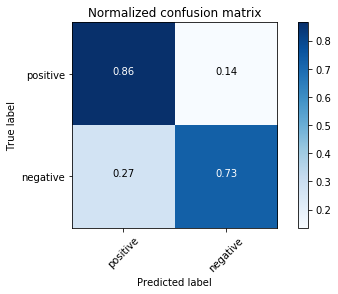

In [29]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Logistic Regression Model

In [30]:
# get object of logistic regression model with cost parameter = 1.1
lg_model = LogisticRegression(C = 1.1) 

In [31]:
# fit our both traing data tweets as well as 
# its sentiments to the logistic regression model
lg_model.fit(X_train_dtm, y_train)

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# do K- fold cross validation on our traing data and 
# its sentimenst with 10 fold cross validation
accuracies = cross_val_score(estimator = lg_model, 
                                X = X_train_dtm, y = y_train, cv = 10) 
# measure the mean accuray of 10 fold cross validation
accuracies.mean() 

0.82286236428833459

In [33]:
# predict the sentiments of testing data tweets
y_pred_lg = lg_model.predict(X_test_dtm)  

In [34]:
# measure the accuracy of our model on the testing data
metrics.accuracy_score(y_test, y_pred_lg) 

0.82521114759028591

In [35]:
# plot the confusion matrix between our predicted sentiments and 
# the original testing data sentiments
confusion_matrix(y_test, y_pred_lg) 

array([[133780,  25967],
       [ 29827, 129634]])

In [36]:
print(classification_report(y_test, y_pred_lg))

             precision    recall  f1-score   support

          0       0.82      0.84      0.83    159747
          4       0.83      0.81      0.82    159461

avg / total       0.83      0.83      0.83    319208



Normalized confusion matrix
[[ 0.84  0.16]
 [ 0.19  0.81]]


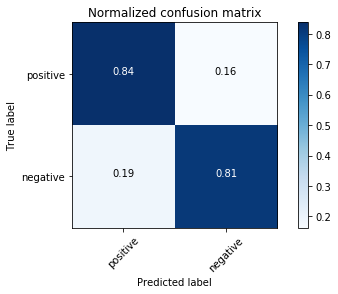

In [41]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# SVM 

In [42]:
svm_model = LinearSVC(random_state=0)

In [43]:
svm_model.fit(X_train_dtm, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [44]:
# do K- fold cross validation on our traing data and 
# its sentimenst with 10 fold cross validation
accuracies = cross_val_score(estimator = svm_model, 
                                 X = X_train_dtm, y = y_train, cv = 10)
# measure the mean accuray of 10 fold cross validation
accuracies.mean() 

0.82462297211458535

In [45]:
# predict the sentiments of testing data tweets
y_pred_svm = svm_model.predict(X_test_dtm)  

In [46]:
# measure the accuracy of our model on the testing data
metrics.accuracy_score(y_test, y_pred_svm)  

0.82544297135410138

In [47]:
# plot the confusion matrix between our predicted sentiments and 
# the original testing data sentiments
confusion_matrix(y_test, y_pred_svm) 

array([[133972,  25775],
       [ 29945, 129516]])

In [48]:
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.82      0.84      0.83    159747
          4       0.83      0.81      0.82    159461

avg / total       0.83      0.83      0.83    319208



Normalized confusion matrix
[[ 0.84  0.16]
 [ 0.19  0.81]]


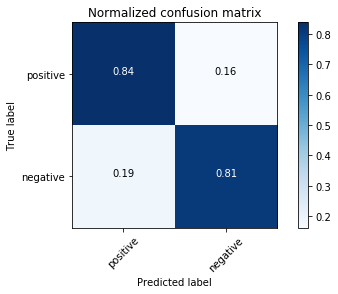

In [50]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Multi-layer Perceptron Classifier

In [57]:
# hidden_layer_sizes=(a, b)
# a : # hidden units
# b : # of hidden layer
mlp_model = MLPClassifier(solver='adam', alpha=1e-5, 
                              hidden_layer_sizes=(3, 3), random_state=1)

In [58]:
mlp_model.fit(X_train_dtm, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [ ]:
# do K- fold cross validation on our traing data and 
# its sentiments with 10 fold cross validation
accuracies = cross_val_score(estimator = mlp_model, 
                                   X = X_train_dtm, y = y_train, cv = 10)
# measure the mean accuray of 10 fold cross validation
accuracies.mean() 

In [59]:
y_pred_mlp = mlp_model.predict(X_test_dtm)

In [60]:
# measure the accuracy of our model on the testing data
metrics.accuracy_score(y_test, y_pred_mlp) 

0.77254999999999996

In [61]:
# plot the confusion matrix between our predicted sentiments and 
# the original testing data sentiments
confusion_matrix(y_test, y_pred_mlp) 

array([[7477, 2410],
       [2139, 7974]])

In [62]:
print(classification_report(y_test, y_pred_mlp))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      9887
          4       0.77      0.79      0.78     10113

avg / total       0.77      0.77      0.77     20000



Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.21  0.79]]


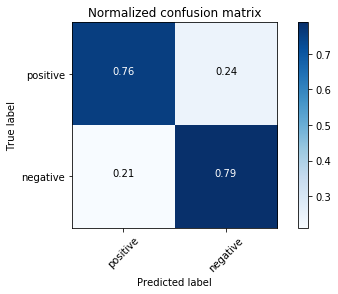

In [65]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()